# Import

In [1]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from PIL import Image
from transformers import AutoModel
from torchvision.io import read_image

device = 'cuda'

/raid/homes/lorenzo.bianchi/miniconda3/envs/talk2dino_hf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Utils

In [2]:
def plot_qualitative(image, sim, palette):
    qualitative_plot = np.zeros((sim.shape[0], sim.shape[1], 3)).astype(np.uint8)

    for j in list(np.unique(sim)):
        qualitative_plot[sim == j] = np.array(palette[j])
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(qualitative_plot, alpha=0.6)
    plt.tight_layout()

# Target Image

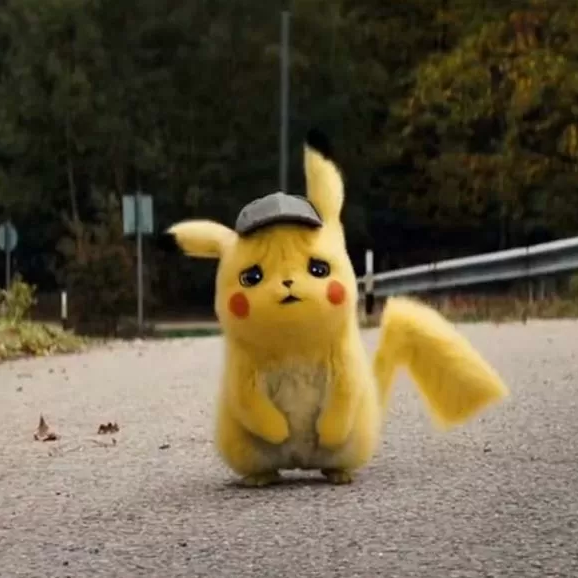

In [3]:
image = Image.open("assets/pikachu.png").convert("RGB")
image

# Model Loading

In [9]:
model = AutoModel.from_pretrained("lorebianchi98/Talk2DINO-ViTB", trust_remote_code=True).to(device).eval()

Using cache found in /raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main
Some weights of the model checkpoint at lorebianchi98/Talk2DINO-ViTB were not used when initializing Talk2DINO: ['pamr.aff_m.kernel', 'pamr.aff_std.kernel', 'pamr.aff_x.kernel']
- This IS expected if you are initializing Talk2DINO from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Talk2DINO from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Mapping Texts & Images in DINOv2 space 

In [5]:
with torch.no_grad():
    text_embed = model.encode_text("a pikachu")
    image_embed = model.encode_image(image)

text_embed.shape, image_embed.shape

(torch.Size([1, 768]), torch.Size([1, 1369, 768]))

In [6]:
# normalize the features to perform cosine similarity
text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)
image_embed = image_embed / image_embed.norm(dim=-1, keepdim=True)

similarity = (image_embed @ text_embed.T).squeeze(0, -1).cpu().numpy()

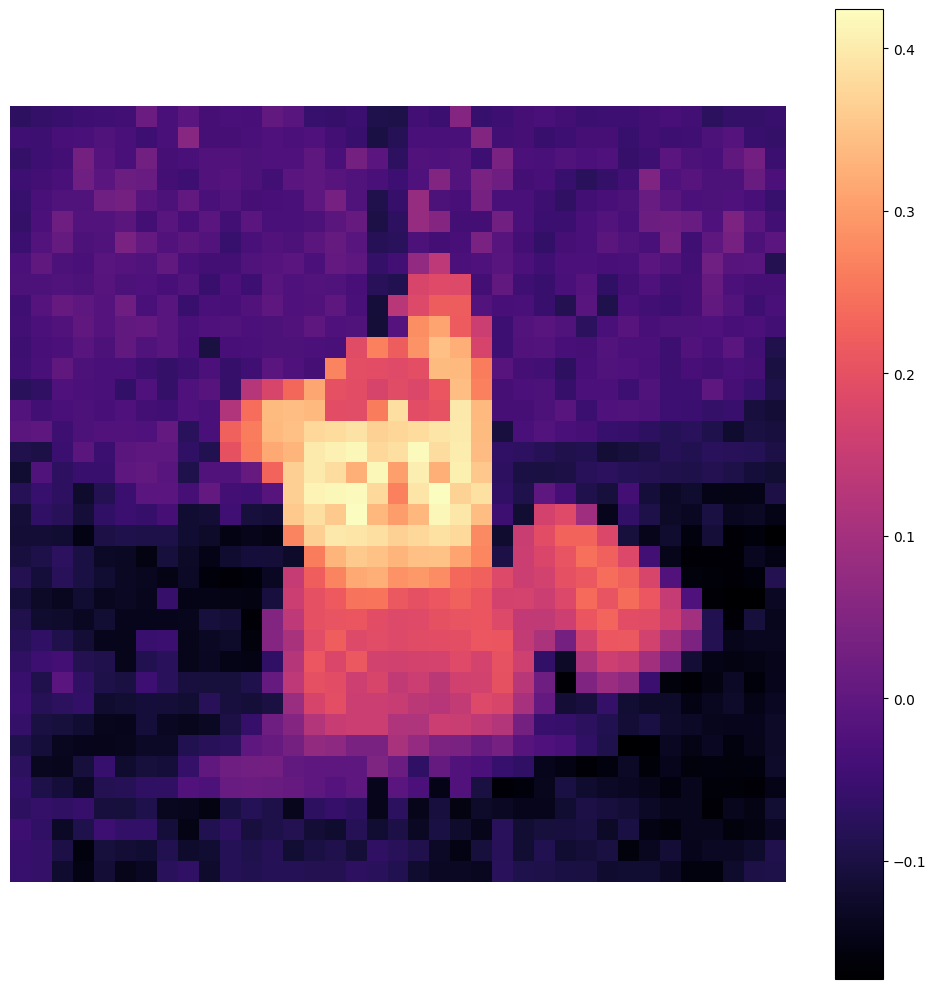

In [7]:
patches_x_row = similarity.shape[0]**0.5
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(similarity.reshape(int(patches_x_row), int(patches_x_row)), cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.show()

# Generate masks

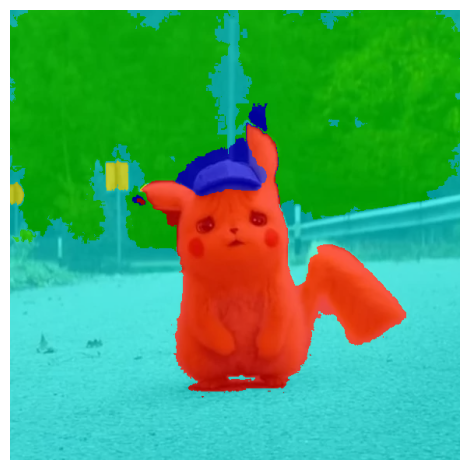

In [8]:
with_background = False
text = "pikachu,traffic_sign,forest,road,cap".replace("_", " ").split(",")
input_file = "assets/pikachu.png"

img = read_image(input_file).to(device).float().unsqueeze(0)
palette = [
    [255, 0, 0],
    [255, 255, 0],
    [0, 255, 0],
    [0, 255, 255],
    [0, 0, 255],
    [128, 128, 128]
]
if len(text) > len(palette):
    for _ in range(len(text) - len(palette)):
        palette.append([np.random.randint(0, 255) for _ in range(3)])
        
if with_background:
    palette.insert(0, [0, 0, 0])
    model.with_bg_clean = True

with torch.no_grad():
    text_emb = model.build_dataset_class_tokens("sub_imagenet_template", text)
    text_emb = model.build_text_embedding(text_emb)
    
    mask, _ = model.generate_masks(img, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)
    if with_background:
        background = torch.ones_like(mask[:, :1]) * 0.55
        mask = torch.cat([background, mask], dim=1)
    
    mask = mask.argmax(dim=1)
    
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), palette)